In [1]:
# Install library for reading JPK File
# %pip uninstall pyafmreader --yes
# %pip install git+https://github.com/jlopezalo/pyafmreader.git

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-j6xh4sij
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-j6xh4sij
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=32767 sha256=bd2970ea81fadd81d0c8381f32ae5a70bdd1fdf86a0864502d3f1a84f8375c6a
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-4r27avo0/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [37]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/testingPyFM/map-data-2021.12.06-19.40.19.296.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [38]:
file = loadfile(file_path)

In [39]:
filemetadata = file.filemetadata
# print(filemetadata)

In [40]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant
    
print(file_spring_constant)
print(deflection_sensitivity)

0.009727186009888375
3.8481407868505814e-08


In [41]:
curve_idx = 0
# curve_idx = 4
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

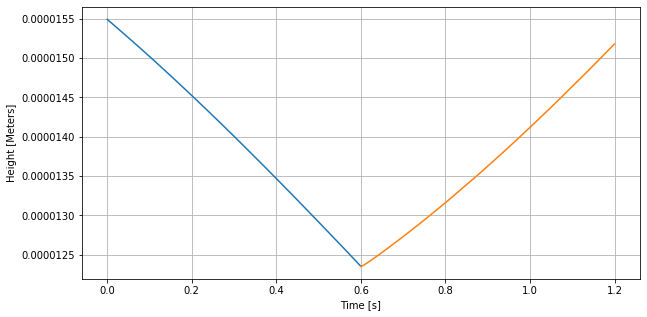

In [42]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    if seg_id == '1':
         height = height[::-1]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

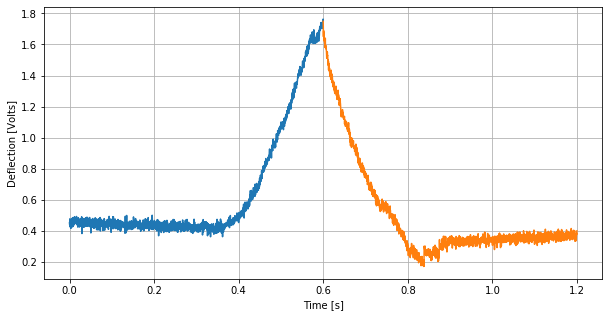

In [43]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

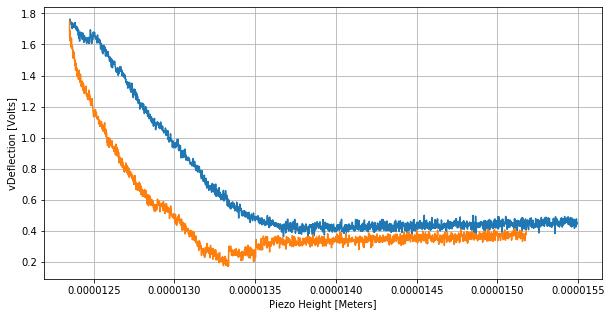

In [44]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [45]:
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)

# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]

In [46]:
# Shift height
force_curve.shift_height()

In [47]:
t_offset = np.abs(first_ext_seg.zheight[-1] - last_ret_seg.zheight[0]) / 150e-6
dt = np.abs(first_ext_seg.time[1] - first_ext_seg.time[0])
print(t_offset > 2 * dt)
if t_offset > 2 * dt:
     last_ret_seg.time = last_ret_seg.time + t_offset

False


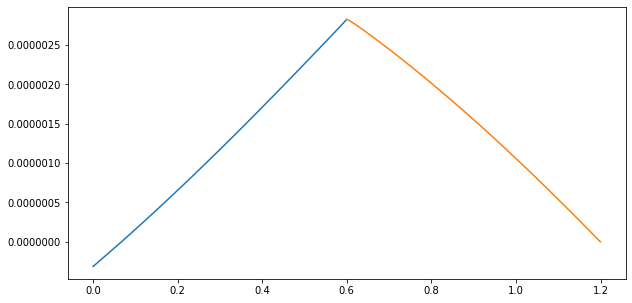

In [48]:
plt.plot(first_ext_seg.time, first_ext_seg.zheight)
plt.plot(last_ret_seg.time + first_ext_seg.time[-1], last_ret_seg.zheight)

In [49]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [50]:
first_ext_seg.velocity
first_ext_seg.segment_metadata

{'time_stamp': '2021-11-05 15\\:41\\:45.097 +0100',
 'num_points': 3000,
 'duration': 0.6000000000000001,
 'channels': ['height', 'vDeflection', 'measuredHeight'],
 'baseline_measured': True,
 'baseline': 0.4363795114745571,
 'approach_id': '2021.11.03-20.06.22-00013',
 'style': 'extend',
 'setpoint': 1.3357704473718137,
 'z_start': 3000.0,
 'z_end': 0.0,
 'ramp_size': -3000.0,
 'ramp_speed': -4999.999999999999}

In [51]:
np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())

3.139533845273956e-06

In [52]:
a = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
a * 1e6

5.232556408789926

In [53]:
a = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
a * 1e6

4.7128368661334905

In [54]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

1.5863563987854109e-06 1.375145042506078e-09


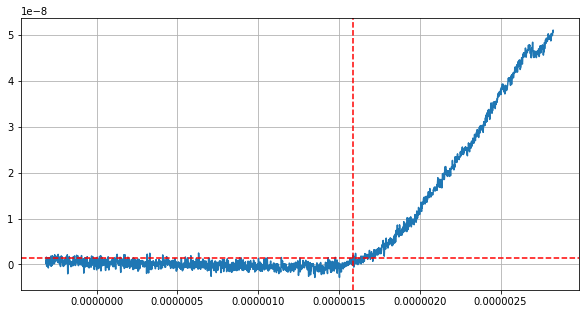

In [55]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [56]:
#plt.plot(app_height, app_deflection)
#mask = app_height<poc[0]
#plt.plot(app_height[mask], app_deflection[mask])
#z = np.poly1d(np.polyfit(app_height[mask], app_deflection[mask], 1))
#plt.plot(app_height[mask], z(app_height[mask]))
#plt.show()
#plt.plot(app_height, app_deflection-z(app_height))
#plt.plot(ret_height, ret_deflection-z(ret_height))
#first_ext_seg.vdeflection = app_deflection-z(app_height)
#last_ret_seg.vdeflection = ret_deflection-z(ret_height)


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: -7.393712965760695e-08

        E0: 1206.6208380852702

        f0: -1.4274400340864506e-11

        slope: None

        # Fit metrics
        MAE: 4.429265286412343e-20

        MSE: 1.2335519932867476e-22

        RMSE: 1.1106538584485932e-11

        Rsq: 0.993995619098217

        Chisq: -8.990169575469353e-09

        RedChisq: -2.9967231918231176e-09

        
1206.6208380852702


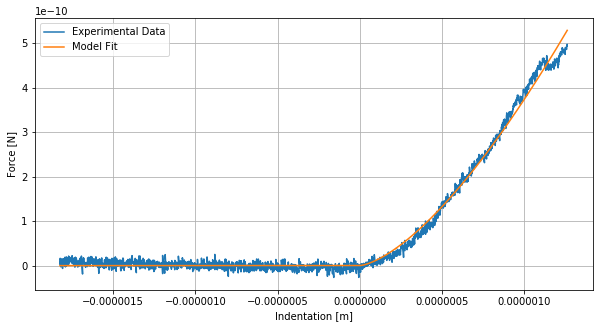

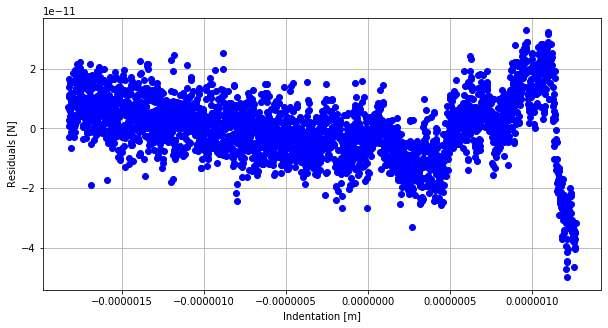

In [57]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

# plt.plot(app_height - poc[0], app_deflection*spring_constant)
# plt.show()

# app_indentation = app_height - poc[0]
# app_force = app_deflection*spring_constant

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

print(hertz_E0)

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [58]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [59]:
indentation = np.r_[app_indentation, ret_indentation]
# yf_app_ind = indentation[-1]
# y0_ret_ind = indentation[0]
idx_tc = (np.abs(app_indentation - 0)).argmin()
# yf_app_f = app_force[-1]
# y0_ret_f = ret_force[0]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
# xf_app = app_time[-1]
# x0_ret = (ret_time + t0)[0]
# dt = time[1] - time[0]
# nbrp_int = int(np.round((x0_ret-xf_app)/dt))
# points = np.linspace(xf_app, x0_ret, num=nbrp_int)
# int_points_f = np.interp(points, [xf_app, x0_ret], [yf_app_f, y0_ret_f])
# int_points_ind = np.interp(points, [xf_app, x0_ret], [yf_app_ind, y0_ret_ind])
# idx_start = nbrp_int//2
# force = np.r_[app_force, int_points_f, ret_force]
# print(points)
# print(int_points)
# plt.plot(app_time, app_indentation, 'o', markersize=2)
# plt.plot(points, int_points_ind, 'o', markersize=2)
# plt.plot(ret_time + t0, ret_indentation, 'o', markersize=2)
# plt.show()
# plt.plot(app_time, app_force, 'o', markersize=2)
# plt.plot(points, int_points_f, 'o', markersize=2)
# plt.plot(ret_time + t0, ret_force, 'o', markersize=2)
# plt.show()
force = np.r_[app_force, ret_force]
tc = time[idx_tc]
fit_mask = indentation > (-1 * 1e-6)
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
idx_tm = np.argmax(force_fit)

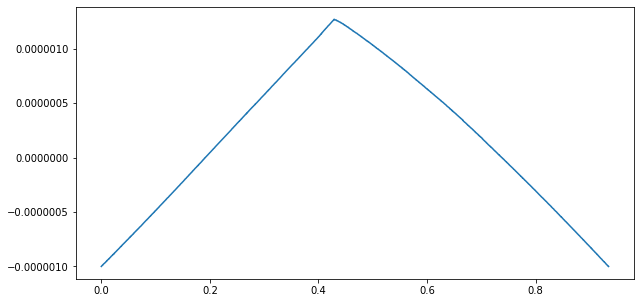

In [60]:
plt.plot(time_fit, ind_fit)

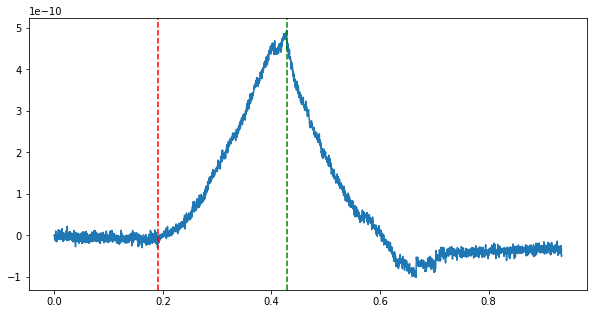

In [61]:
plt.plot(time_fit, force_fit)
plt.axvline(x=tc_fit, color='r', linestyle='--')
plt.axvline(x=tm, color='g', linestyle='--')
plt.show()

In [62]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, 

In [63]:
#from lmfit import Model,Parameters
#ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
#model =\
#    lambda time, E0, tc, betaE, F0:\
#    ting_model_num.model(time, E0, tc, betaE, F0, t0=1, F=force_fit, delta=ind_fit, modelFt='numerical', vdrag=0, idx_tm=idx_tm, smooth_w=1, v0t=None, v0r=None)
#gmodel = Model(model)
#params = Parameters()
#params.add('E0', value=hertz_E0, min=hertz_E0*0.001, max=hertz_E0*1e5)
#params.add('tc', value=tc_fit, min=tc_fit/10, max=tc_fit*10)
#params.add('betaE', value=0.49, min=0, max=1)
#params.add('F0', value=0)
#print(f'parameter names: {gmodel.param_names}')
#print(f'independent variables: {gmodel.independent_vars}')
#result = gmodel.fit(force_fit, params, time=time_fit)
#print(result.fit_report())
#plt.plot(time_fit, force_fit, 'o')
# plt.plot(time_fit, result.init_fit, '--', label='initial fit')
#plt.plot(time_fit, result.best_fit, '-', label='best fit')
#plt.legend()
#plt.show()

In [87]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.betaE_init = 0.4
ting_model_num.E0_init = hertz_E0
ting_model_num.tc_init = tc_fit
# ting_model_num.vdrag = 1.1e3/1e9
ting_model_num.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=1)
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 2141

        Number of free parameters: 4

        E0: 567.2929633382902

        tc: 0.17699257776109067

        betaE: 0.2406835863162002

        F0: -3.9062187738315133e-11

        # Fit metrics
        MAE: 2.016130610325653e-12

        MSE: 5.917038414495613e-22

        RMSE: 2.43249633391206e-11

        Rsq: 0.9735620816280219

        Chisq: -3.430863889818695e-08

        RedChisq: -8.577159724546738e-09

        


In [88]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.betaE_init = 0.4
ting_model_analit.E0_init = hertz_E0
ting_model_analit.tc_init = tc_fit
#ting_model_analit.vdrag = 1.1e3/1e9
ting_model_analit.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=1)
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 2141

        Number of free parameters: 4

        E0: 615.9440904983037

        tc: 0.19759296024410958

        betaE: 0.25168657790856147

        F0: -2.9770530554570724e-11

        # Fit metrics
        MAE: -4.803068110070256e-14

        MSE: 3.980425686993396e-22

        RMSE: 1.9951004202779858e-11

        Rsq: 0.9820921434829956

        Chisq: 3.719857841906746e-07

        RedChisq: 9.299644604766866e-08

        


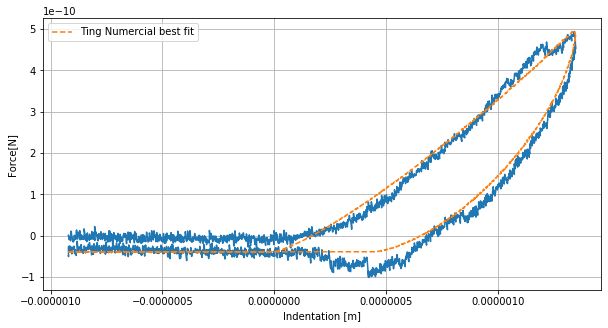

In [89]:
idx_tc = (np.abs(time_fit - tc_num)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit)
plt.plot(ind_fit-delta0, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=1), '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

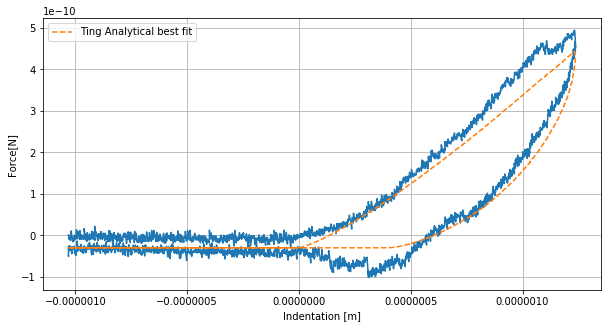

In [90]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit)
plt.plot(ind_fit-delta0, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=1), '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

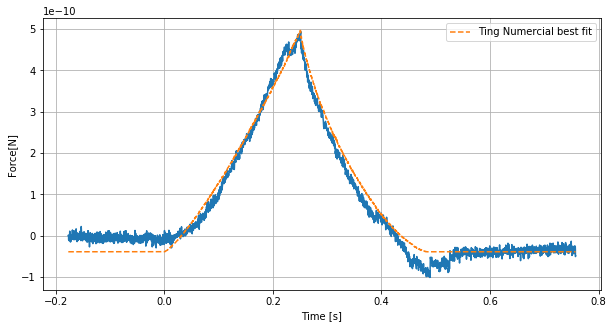

In [91]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=1), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

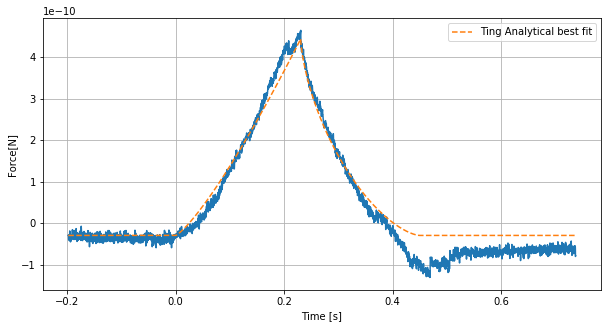

In [92]:
plt.plot(time_fit-tc_analit, force_fit+f0_analit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=1), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()